# Is CSpace respecting the tree-structure of the embedded ontologies?

In this notebook we check if CSpace embeddings respect the tree-structure of the embedded concepts (MeSH, Gene ID, TAX ID)

we start from a random concept in MeSH and try to reconstruct their sibilings and his parent recursively.

In [4]:
from IPython.display import Image
import re
import numpy as np
from commonalities import get_names
from utils import navigate_mesh_ontology

In [2]:
from gensim.models import KeyedVectors

model = KeyedVectors.load('models/cspace.kv.bin','r')

In [2]:
# cspace embedding of Tuberculosis: D014376 is the MeSH ID of Tuberculosis
concept_id='d014376'
concept_name='Tuberculosis'
concept='disease_mesh_'+concept_id
concept_pattern=re.compile("\\bdisease_mesh_[cd][0-9]+\\b")

In [4]:
concept_pattern.search('non-'+concept+'-ild').group()

'disease_mesh_d014376'

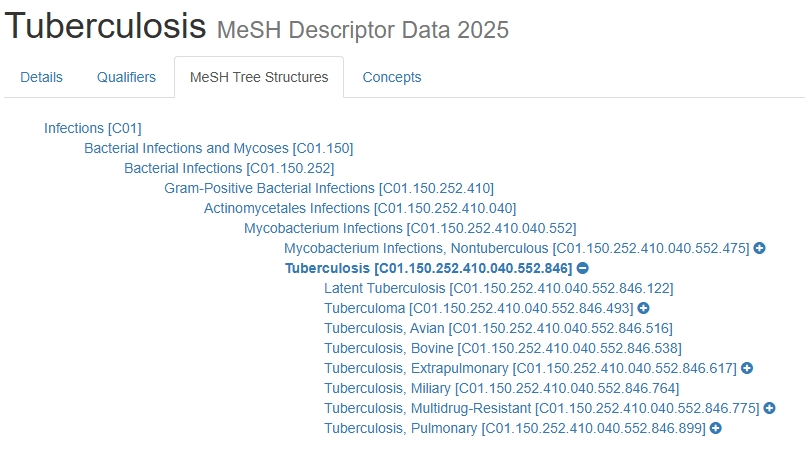

In [14]:
Image("images\\tuberculosis_tree.jpeg")

In [21]:
concepts={}
for k,v in model.most_similar(concept, topn=1000):
    m = concept_pattern.search(k)
    if m is not None:
        if m.group() not in concepts:
            concepts[ m.group() ]=[v]
        else:
            concepts[ m.group() ].append(v)

concept_items = concepts.items()
concept_names = list(get_names(concept_items))

In [22]:
tree_jump_treshold=0.05
curl=[]
hierarchy = [curl]
for i,((cid,vals),(cn, vals)) in enumerate(sorted(zip(concept_items,concept_names), key=lambda vl: sum(vl[0][1])/len(vl[0][1]), reverse=True)):
    avg=sum(vals)/len(vals)
    if i == 0:
        prev = avg
    elif abs(prev-avg) <= tree_jump_treshold:
        curl.append((cid,cn,avg))
    else:
        # tree jump
        curl = [(cid,cn,avg)]
        hierarchy.append(curl)
        prev=avg    
    #vstr=', '.join(sorted(["{:.4f}".format(v) for v in vals], reverse=True))
    print(f"{cn} ({avg:.4f} N={len(vals)})")

d0143769606 (0.9292 N=1)
Tuberculosis (0.9245 N=228)
Tuberculosis, Avian (0.9164 N=1)
Tuberculosis, Cardiovascular (0.9147 N=1)
Tuberculosis, Miliary (0.9137 N=1)
Tuberculosis, Female Genital (0.9131 N=1)
Tuberculosis, Hepatic (0.9113 N=1)
Tuberculosis, Laryngeal (0.9048 N=1)
Tuberculosis, Endocrine (0.9033 N=1)
Tuberculosis, Meningeal (0.9011 N=49)
Tuberculosis, Gastrointestinal (0.8989 N=1)
Tuberculosis, Bovine (0.8946 N=2)
Tuberculosis, Ocular (0.8925 N=1)
d0143909606 (0.8911 N=1)
d0143979606 (0.8881 N=1)
Tuberculosis, Pulmonary (0.8863 N=24)
Tuberculosis, Lymph Node (0.8845 N=5)
Tuberculosis, Renal (0.8798 N=1)
Tuberculosis, Pleural (0.8783 N=5)
Tuberculosis, Male Genital (0.8707 N=1)
Peritonitis, Tuberculous (0.8700 N=3)
Tuberculosis, Spinal (0.8634 N=5)
Mycobacterium Infections (0.8634 N=1)
Tuberculosis, Oral (0.8633 N=1)
Tuberculosis, Urogenital (0.8585 N=1)
Tuberculosis, Cutaneous (0.8573 N=3)
Tuberculosis, Osteoarticular (0.8529 N=5)
Diabetes Mellitus (0.8429 N=1)
Tuberculoma 

Same-level and parent concepts are in this list! (and also others not reported in MeSH browser) check the difference with the base concept

In [24]:
#hierarchy
for level,curl in enumerate(reversed(hierarchy)):
    for cid,cn,avg in curl:
        print(f"{'    '*level}{cn} {avg:.4f}")
    

Tuberculosis, Splenic 0.8271
AIDS-Related Opportunistic Infections 0.8242
Pleuropneumonia, Contagious 0.8236
Leprosy 0.8215
Tuberculosis, Multidrug-Resistant 0.8213
Tuberculoma, Intracranial 0.8188
Lupus Vulgaris 0.8179
Buruli Ulcer 0.8160
Caplan Syndrome 0.8157
Scarlet Fever 0.8107
Ascaridiasis 0.8101
Lymphadenitis 0.8101
Poliomyelitis, Bulbar 0.8091
HIV Infections 0.8089
Syphilis 0.8088
Cysticercosis 0.8063
Basal Ganglia Diseases 0.8048
Measles 0.8040
Pneumocystis Infections 0.8037
d0031411 0.8036
Plague 0.8033
Noncommunicable Diseases 0.8021
Histrionic Personality Disorder 0.8021
Brucellosis 0.8018
Granuloma 0.8012
Trombiculiasis 0.8008
Acquired Immunodeficiency Syndrome 0.8008
Lung Diseases, Parasitic 0.8007
Lung Diseases 0.8003
Pleurisy 0.7999
Chagas Disease 0.7997
Malaria 0.7994
Infections 0.7991
Trypanosomiasis, African 0.7988
Granuloma Inguinale 0.7985
Lung Diseases, Fungal 0.7982
Rigor Mortis 0.7979
Sarcoidosis 0.7978
Communicable Diseases 0.7975
Myotonic Dystrophy 0.7975
Pneu

With this trivial method, the resulting hierarchy is very different from the one in MeSH ontology, but it is much more rich. 

This may raise from the superposition effect described by anthropic researchers.

To enforce coherence with ontology, that may be missed by looking at free-text, we should do something similar to BioWord2Vec that **samples from MeSH trees to generate sentences**.

Try the **other way around**: sample a-posteriori from the tree, and check the similarity between elements in the CSpace

In [16]:

navigate_mesh_ontology(concept_id.upper())

(['D009164', 'D000193', 'D016908', 'D001424', 'D001423'],
 ['Mycobacterium Infections',
  'Actinomycetales Infections',
  'Gram-Positive Bacterial Infections',
  'Bacterial Infections',
  'Bacterial Infections and Mycoses'],
 ['D007239'],
 ['Infections'])

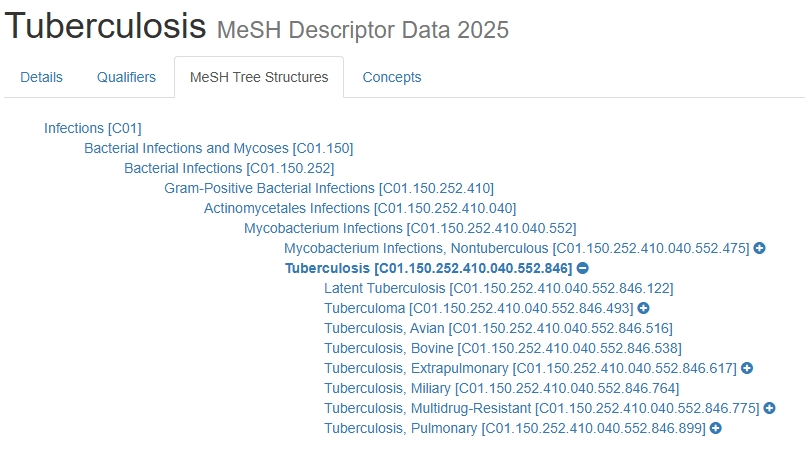

In [5]:
Image("images\\tuberculosis_tree.jpeg")

Now use the helper function `navigate_mesh_ontology` to construct the tree, and CSpace to measure the similarity difference between parent and child elements

In [28]:
middle_ids,middle_names,top_ids,top_names = navigate_mesh_ontology(concept_id.upper())

for tid,tname in zip(top_ids,top_names):
    val = model.similarity('disease_mesh_'+tid.lower(),concept)
    parent_val = val
    print(f"{tname} ({val:.4f})")
        
for i,(mid,mname) in enumerate(reversed(list(zip(middle_ids,middle_names)))):
    val = model.similarity('disease_mesh_'+mid.lower(),concept)
    print(f"{'    '*i}{mname} ({val:.4f}) (parent diff: {val-parent_val:.4f})")
    parent_val = val

val = 1.0
print(f"{'    '*(i+1)}{concept_name} ({val:.4f}) (parent diff: {val-parent_val:.4f})")
parent_val=1.0

# check also first-childs of named concept
for j,(cid,cn,avg) in enumerate(hierarchy[0]):
    print(f"{'    '*(i+2)}{cn} ({avg:.4f}) (parent diff: {avg-parent_val:.4f})")


Infections (0.7693)
Bacterial Infections and Mycoses (0.7705) (parent diff: 0.0012)
    Bacterial Infections (0.7432) (parent diff: -0.0273)
        Gram-Positive Bacterial Infections (0.7909) (parent diff: 0.0477)
            Actinomycetales Infections (0.7194) (parent diff: -0.0715)
                Mycobacterium Infections (0.8634) (parent diff: 0.1440)
                    Tuberculosis (1.0000) (parent diff: 0.1366)
                        Tuberculosis (0.9245) (parent diff: -0.0755)
                        Tuberculosis, Avian (0.9164) (parent diff: -0.0836)
                        Tuberculosis, Cardiovascular (0.9147) (parent diff: -0.0853)
                        Tuberculosis, Miliary (0.9137) (parent diff: -0.0863)
                        Tuberculosis, Female Genital (0.9131) (parent diff: -0.0869)
                        Tuberculosis, Hepatic (0.9113) (parent diff: -0.0887)
                        Tuberculosis, Laryngeal (0.9048) (parent diff: -0.0952)
                        Tub

It appears that the more specific the concept, the higher the difference in cosine similarity between parent and child.

This may reflect the fact that CSpace cannot capture very distant, high level relationships such as the one from **Actinomycetales Infections** and **Mycobacterium Infections**

that rarely occur in literature. This may be fixed by adding sentences sampled from ontology, something similar to BioWord2Vec.

In [20]:
from pubtator_utils import *

l=[(None, 0, 1, model.similarity('disease_mesh_d000193','disease_mesh_d009164'), None)]
m={0:"Actinomycetales Infections",1:"Mycobacterium Infections"}

# 2) Provide a name lookup that maps row index -> PubTator concept name
def name_lookup(i: int) -> str:
    return m[i]

# 3) Count literature hits for each set (optionally pass api_key="..."):
count_pairs_in_literature(l, name_lookup=name_lookup, entity_prefix="@DISEASE_", api_key=None)

[{'i': 0,
  'j': 1,
  'name_i': 'Actinomycetales Infections',
  'name_j': 'Mycobacterium Infections',
  'cosine': 0.8237468004226685,
  'count': 4}]

Let's now compute some statistics on many diseases, not just one, to see if this pattern is preserved among different diseases.

In [8]:
import pickle
# see cspace_ontology_distributions notebook for the code to generate this file
with open('models/Wdata.pkl','rb') as f:
    Wdata = pickle.load(f)

disease=1
Wlen = Wdata['idxs']['disease']
Wpath = Wdata['paths'][disease]
dmap = Wdata['maps'][disease]
print(list(dmap.items())[:10])

dlist = list(dmap.values())
n_diseases=len(dlist)
max_levels=50

print(f"Total number of diseases: {Wlen}")

[(0, 'disease_mesh_d009369'), (1, 'disease_mesh_d007239'), (2, 'disease_mesh_d003643'), (3, 'disease_mesh_d003920'), (4, 'disease_mesh_d010146'), (5, 'disease_mesh_d000275'), (6, 'disease_mesh_d007249'), (7, 'disease_mesh_d009765'), (8, 'disease_mesh_d001943'), (9, 'disease_mesh_d064420')]
Total number of diseases: 5604


In [5]:
# get children with CSpace, parents with MeSH ontology
from ontology_tree import ontology_tree_distance

tree_jump_treshold=0.05
model.fill_norms()

# matrix of differences in cosine similarity between different levels in ontology associated with diseases in dlist 
# shape=(n_diseases,max_levels)
diff_matrix = ontology_tree_distance(model, dlist, max_levels, concept_pattern, tree_jump_treshold, verbose=True)

Processing disease_mesh_d009369...
Neoplasms (1.0000) (parent diff: nan)
    d0093692 (0.9669) (parent diff: -0.0331)
    Neoplasms (0.9533) (parent diff: -0.0467)
    d0093699 (0.9641) (parent diff: -0.0359)
    d0093694 (0.9624) (parent diff: -0.0376)
    d0093693 (0.9613) (parent diff: -0.0387)
    d0093698 (0.9573) (parent diff: -0.0427)
    d00936923 (0.9542) (parent diff: -0.0458)
    d0093691 (0.9542) (parent diff: -0.0458)
Processing disease_mesh_d007239...
Processing disease_mesh_d003643...
Processing disease_mesh_d003920...
Processing disease_mesh_d010146...
Processing disease_mesh_d000275...
Processing disease_mesh_d007249...
Processing disease_mesh_d009765...
Processing disease_mesh_d001943...
Processing disease_mesh_d064420...
Processing disease_mesh_d006973...
Processing disease_mesh_d000544...
Processing disease_mesh_d020521...
Processing disease_mesh_d001523...
Processing disease_mesh_d010300...
Processing disease_mesh_d050723...
Processing disease_mesh_d012640...
Proce

In [10]:
diff_matrix[:3,:]

array([[-4.0805832e-02,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [-4.9751904e-02,            nan,            nan,            nan,
                   nan,

In [9]:
ontodiff_path = 'models/Wontodiff_top_excluded.npy'

Wontodiff = np.memmap(ontodiff_path, mode="w+", dtype=np.float32, shape=(n_diseases, max_levels))
Wontodiff[:,:] = diff_matrix
# persist to disk
Wontodiff.flush()

In [9]:
ontodiff_path = 'models/Wontodiff_top_excluded.npy'
Wontodiff = np.memmap(ontodiff_path, mode="r", dtype=np.float32, shape=(n_diseases, max_levels))

In [10]:
# NOTE: we are excluding the difference with the top level that is a too high level concept
# compute mean and variance for every level across all n_diseases
# shape=(max_levels,)
levels_count = n_diseases-np.sum(np.isnan(Wontodiff), axis=0)
levels_mean = np.nansum(Wontodiff, axis=0) / levels_count
# broadcast by row
levels_vars = np.nansum(np.square(Wontodiff-levels_mean), axis=0) / (n_diseases-np.sum(np.isnan(Wontodiff), axis=0))

print(levels_count)
print(levels_mean)
print(levels_vars)

[5554 5003 4758 4134 3438 2728 2114 1539 1169  870  646  477  359  265
  199  148  115   87   66   43   33   23   15   11    7    4    4    4
    4    3    3    3    2    2    2    2    1    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[ 0.00357095  0.03172128  0.02586778  0.02223284  0.0208109   0.01885176
  0.01306591  0.01323447  0.01258749  0.00927227  0.0126546   0.01689542
  0.01108262  0.02199599  0.00744209  0.02435814  0.04157331  0.01652582
  0.00497975  0.0226076   0.00212422  0.01476414  0.00430234  0.0284698
  0.00019995  0.02298898  0.01147594 -0.02965519  0.10382882 -0.01081757
  0.03623176 -0.00715951 -0.00769985  0.03732297  0.0948709   0.02805605
 -0.13884737         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan]
[0.00556595 0.0095686  0.01095741 0.01138584 0.01230431 0.0126158
 0.01214942 0.01237645 0.01215096 0.01322523 0.01331806 0.01325672
 0.

C:\Users\tomasoni\AppData\Local\Temp\ipykernel_27392\4062146440.py:5: RuntimeWarning: invalid value encountered in divide
  levels_mean = np.nansum(Wontodiff, axis=0) / levels_count
C:\Users\tomasoni\AppData\Local\Temp\ipykernel_27392\4062146440.py:7: RuntimeWarning: invalid value encountered in divide
  levels_vars = np.nansum(np.square(Wontodiff-levels_mean), axis=0) / (n_diseases-np.sum(np.isnan(Wontodiff), axis=0))


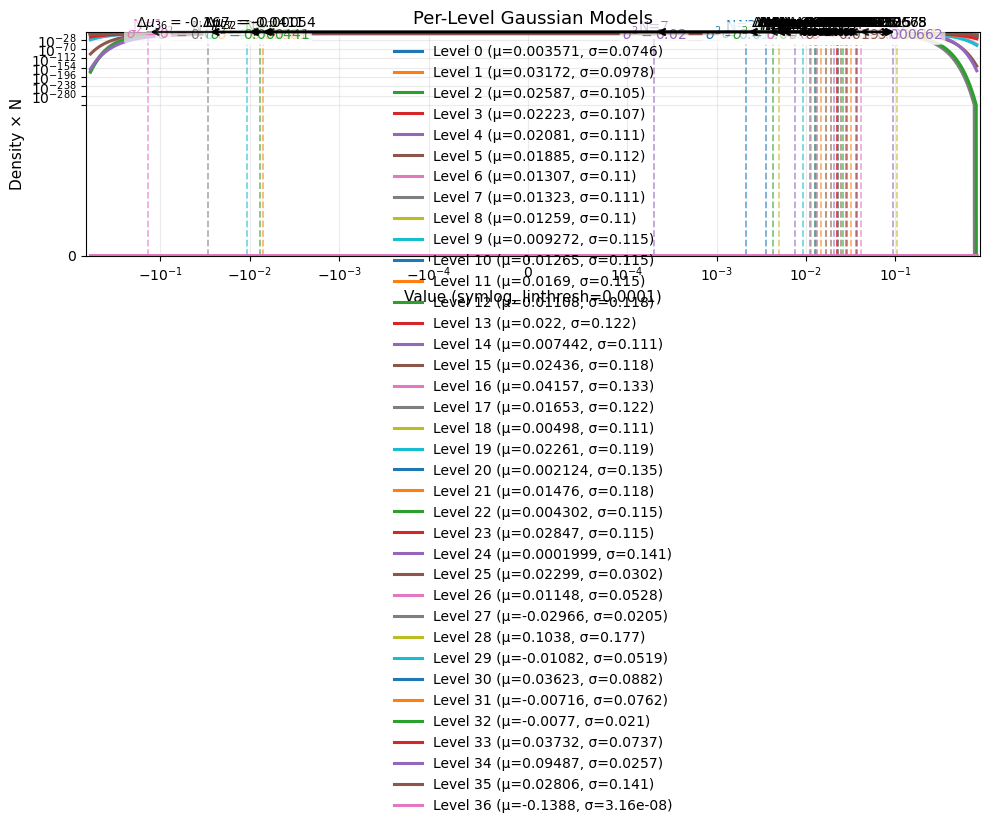

In [11]:
from ontology_tree import plot_level_gaussians

plot_level_gaussians(levels_count, levels_mean, levels_vars,
                     xscale="symlog", yscale="log", neglog_y=False,
                     scale_by_count=True, linthreshx=1e-4)

There's no clear difference between the levels, CSpace doesn't encode this information out of the box.

**Next version will try to encode also these hierarchies.**